In [1]:
import sys
sys.path.append('/home/dboiko/simg-2')

import os
os.chdir('/home/dboiko/simg-2')

In [2]:
PATH = '/home/dboiko/simg/new_xyzs/xyz/'

In [3]:
import time
import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np

import torch

from simg.model_utils import pipeline
from simg.data import get_connectivity_info
from simg.graph_construction import convert_NBO_graph_to_downstream

def xyz_to_graph(xyz_path, target, type_):
    with open(xyz_path, "r") as f:
        xyz = f.read()

    xyz_data = [l + '\n' for l in xyz.split('\n')[2:-1]]
    symbols = [l.split()[0] for l in xyz_data]
    coordinates = np.array([[float(num) for num in l.strip().split()[1:]] for l in xyz_data])
    connectivity = get_connectivity_info(xyz_data)

    graph, _, _, (a2b_preds, node_preds, int_preds) = pipeline(symbols, coordinates, connectivity, use_threshold=False)

    graph.y = torch.FloatTensor(node_preds)
    graph.a2b_targets = torch.FloatTensor(a2b_preds)
    graph.interaction_targets = torch.FloatTensor(int_preds)
    graph.qm9_id = xyz_path.split('/')[-1].split('.')[0]

    graph.type = type_
    graph.normalized_targets = torch.FloatTensor([target])
    graph = convert_NBO_graph_to_downstream(graph)

    return graph, len(symbols)

/home/dboiko/.conda/envs/nbo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using full GNN model
Stacking all GNN layer outputs


In [4]:
from tqdm.auto import tqdm, trange

In [5]:
xyzs = os.listdir(PATH)
ATTEMPTS = 10

results = []

for i, xyz in enumerate(tqdm(xyzs)):
    print(f'{i}/{len(xyzs)}')
    for _ in range(ATTEMPTS):
        time_0 = time.time()
        graph, n_atoms = xyz_to_graph(PATH + xyz, 0, 'train')
        time_1 = time.time()

        results.append((xyz, n_atoms, time_1 - time_0))

  0%|                                                                                                                        | 0/15 [00:00<?, ?it/s]

0/15


  7%|███████▍                                                                                                        | 1/15 [00:01<00:15,  1.07s/it]

1/15


 13%|██████████████▉                                                                                                 | 2/15 [00:05<00:39,  3.01s/it]

2/15


 20%|██████████████████████▍                                                                                         | 3/15 [00:07<00:29,  2.46s/it]

3/15


 27%|█████████████████████████████▊                                                                                  | 4/15 [00:10<00:29,  2.67s/it]

4/15


 33%|█████████████████████████████████████▎                                                                          | 5/15 [00:11<00:22,  2.25s/it]

5/15


 40%|████████████████████████████████████████████▊                                                                   | 6/15 [00:14<00:22,  2.45s/it]

6/15


 47%|████████████████████████████████████████████████████▎                                                           | 7/15 [00:15<00:15,  1.91s/it]

7/15


 53%|███████████████████████████████████████████████████████████▋                                                    | 8/15 [00:16<00:11,  1.64s/it]

8/15


 60%|███████████████████████████████████████████████████████████████████▏                                            | 9/15 [00:18<00:10,  1.72s/it]

9/15


 67%|██████████████████████████████████████████████████████████████████████████                                     | 10/15 [00:20<00:08,  1.80s/it]

10/15


 73%|█████████████████████████████████████████████████████████████████████████████████▍                             | 11/15 [00:27<00:13,  3.30s/it]

11/15


 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 12/15 [00:27<00:07,  2.56s/it]

12/15


 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏              | 13/15 [00:29<00:04,  2.18s/it]

13/15


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 14/15 [00:29<00:01,  1.76s/it]

14/15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:34<00:00,  2.30s/it]


In [6]:
import pandas as pd

df = pd.DataFrame(results, columns=['path', 'n_atoms', 'time']).groupby('path').mean().reset_index()

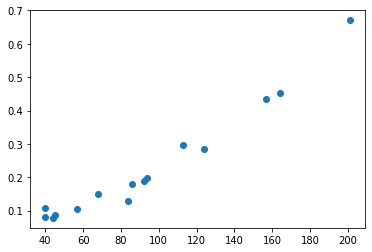

In [7]:
import matplotlib.pyplot as plt

plt.scatter(df['n_atoms'], df['time'])

In [11]:
import pickle as pkl

with open('/home/dboiko/SPAHM/code/times.pkl', 'rb') as f:
    times = pd.DataFrame(pkl.load(f), columns=['xyz', 'time']).groupby('xyz').mean().reset_index()

In [12]:
times

,xyz,time
0,1n6t.xyz,0.903944
1,2gfr.xyz,1.052183
2,2n0v.xyz,0.532768
3,amitriptilin.xyz,0.221570
4,coproporphyrinogenIII.xyz,0.394237
5,donepezil.xyz,0.234596
6,fluoxetin.xyz,0.209907
7,gisenosides.xyz,0.305801
8,morphin.xyz,0.229657
9,natamycin.xyz,0.368499


In [15]:
merged_times = df.merge(times, left_on='path', right_on='xyz', how='outer')

In [30]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

plt.rcParams["pdf.fonttype"] = 42


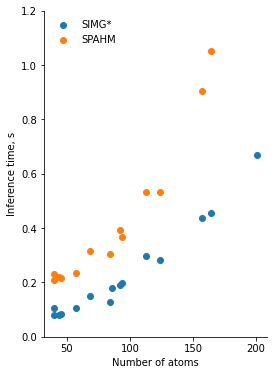

In [44]:
plt.figure(figsize=(4, 6))
plt.scatter(
    merged_times['n_atoms'],
    merged_times['time_x'],
    label='SIMG*',
)

plt.scatter(
    merged_times['n_atoms'],
    merged_times['time_y'],
    label='SPAHM',
)
plt.xlabel('Number of atoms')
plt.ylabel('Inference time, s')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.ylim(0, 1.2)
plt.legend(frameon=False, loc='upper left')
plt.savefig('/home/dboiko/simg_vs_spahm_time.pdf', dpi=300, bbox_inches='tight')

In [10]:
df.to_csv(
    'simg_xyz_time_2.csv',
)